In [1]:
# We will download data from Kaggle (see dedicated tutorial for explanation)
# Assuming you have your kaggle.json in the local folder
!ls -l kaggle.json
# We set the environment variable to point to the folder where kaggle.json is saved
import os
os.environ["KAGGLE_CONFIG_DIR"]= os.environ["PWD"]

-rw-------  1 karolos  staff  63 Dec  6 00:13 kaggle.json


In [2]:
# We'll download this dataset from https://www.kaggle.com/datasets/aryanfelix/brats-2019-traintestvalid
!kaggle datasets download -d aryanfelix/brats-2019-traintestvalid -p ./kaggle_BraTS2019/ --unzip

# There's a more complete dataset at https://www.kaggle.com/datasets/aryashah2k/brain-tumor-segmentation-brats-2019
# But it is much bigger
#!kaggle datasets download aryashah2k/brain-tumor-segmentation-brats-2019

# If you use this dataset, you can have a look at
# https://blog.tensorflow.org/2018/07/an-introduction-to-biomedical-image-analysis-tensorflow-dltk.html

 99%|█████████████████████████████████████▍| 62.0M/62.9M [00:02<00:00, 42.6MB/s]
100%|██████████████████████████████████████| 62.9M/62.9M [00:02<00:00, 28.6MB/s]


Let's take a look at the data.

In [3]:
!ls ./kaggle_BraTS2019/dataset
!for d in ./kaggle_BraTS2019/dataset/{train,valid}/{yes,no} ; do echo $d; ls ${d} | head -n10 ; done

test  train valid
./kaggle_BraTS2019/dataset/train/yes
y0.jpg
y1.jpg
y10.jpg
y100.jpg
y1000.jpg
y1001.jpg
y1002.jpg
y1003.jpg
y1004.jpg
y1005.jpg
./kaggle_BraTS2019/dataset/train/no
No12.jpg
No13.jpg
No14.jpg
No15.jpg
No17.jpg
No18.jpg
No19.jpg
no0.jpg
no1.jpg
no10.jpg
./kaggle_BraTS2019/dataset/valid/yes
y1400.jpg
y1401.jpg
y1402.jpg
y1403.jpg
y1404.jpg
y1405.jpg
y1406.jpg
y1407.jpg
y1408.jpg
y1409.jpg
./kaggle_BraTS2019/dataset/valid/no
no1400.jpg
no1401.jpg
no1402.jpg
no1403.jpg
no1404.jpg
no1405.jpg
no1406.jpg
no1407.jpg
no1408.jpg
no1409.jpg


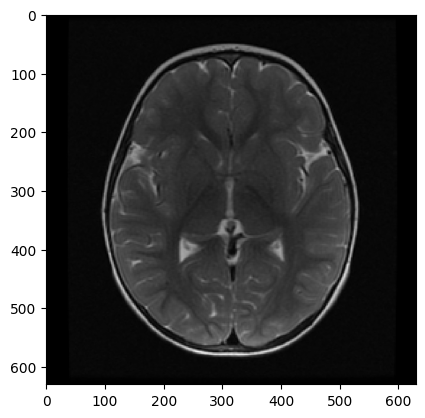

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("./kaggle_BraTS2019/dataset/test/N1.jpeg"))

In [5]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./kaggle_BraTS2019/dataset/train", labels='inferred', label_mode='binary', color_mode='grayscale')
print(train_ds.class_names)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    "./kaggle_BraTS2019/dataset/valid", labels='inferred', label_mode='binary', color_mode='grayscale')
print(valid_ds.class_names)

2023-12-06 02:33:39.827235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2800 files belonging to 2 classes.
['no', 'yes']
Found 200 files belonging to 2 classes.
['no', 'yes']


In [6]:
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [7]:
num_classes = len(train_ds.class_names)
input_shape = (256, 256, 1)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu' ),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu' ),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=(3,3), activation='relu' ),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss= "binary_crossentropy", optimizer='adam', metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       7

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 2, verbose= 1, mode='auto')
mc = ModelCheckpoint(filepath="./kaggle_BraTS2019/working/best_model.keras",monitor='val_accuracy',save_best_only = True )

In [12]:
model.fit(
    x=train_ds,
    validation_data=valid_ds,
    epochs=5,
    callbacks = [mc,es],
    steps_per_epoch=20)

Epoch 1/5
20/20 [==============================] - 62s 3s/step - loss: 0.2749 - accuracy: 0.8828 - val_loss: 0.4065 - val_accuracy: 0.8350
Epoch 2/5
20/20 [==============================] - 52s 3s/step - loss: 0.2204 - accuracy: 0.9172 - val_loss: 0.3470 - val_accuracy: 0.8900
Epoch 3/5
20/20 [==============================] - 55s 3s/step - loss: 0.1645 - accuracy: 0.9391 - val_loss: 0.4129 - val_accuracy: 0.8850
Epoch 4/5
20/20 [==============================] - 53s 3s/step - loss: 0.2054 - accuracy: 0.9125 - val_loss: 0.3943 - val_accuracy: 0.8750
Epoch 4: early stopping


<Axes: >

<Figure size 1200x1000 with 0 Axes>

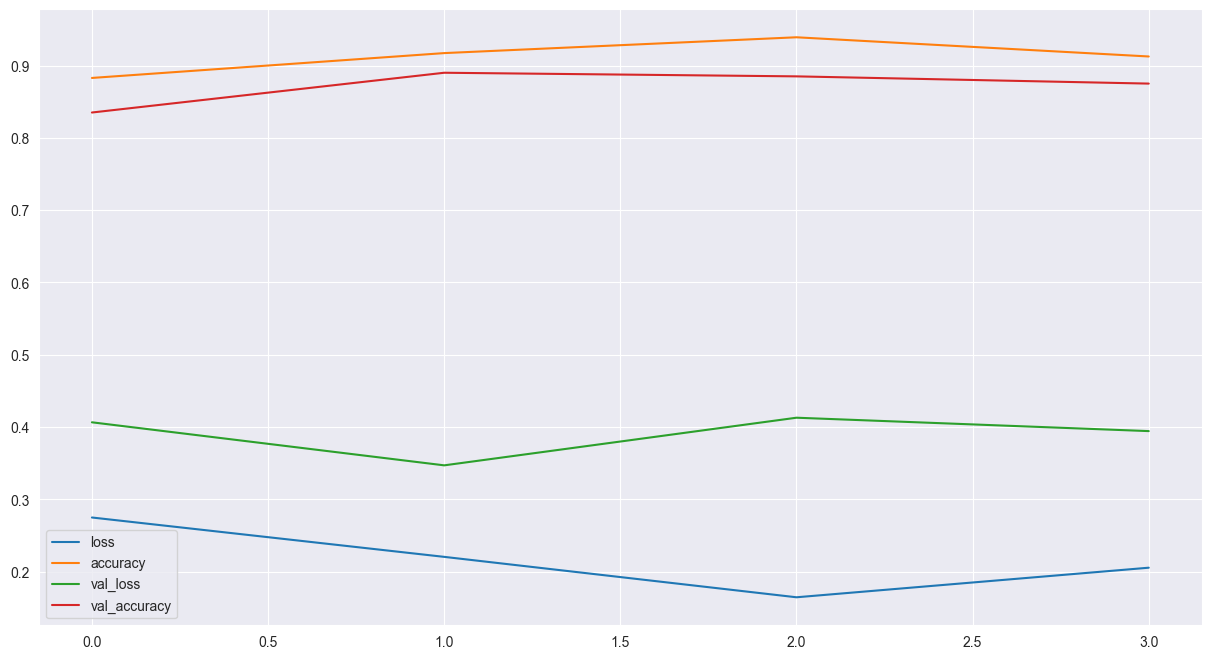

In [13]:
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
pd.DataFrame(model.history.history).plot(figsize=(15,8))

In [17]:
from keras.preprocessing import image
import numpy as np

def predict(img_loc):
    img=image.load_img(img_loc, grayscale=True, target_size=(256,256))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    result=model.predict(img)
    print(result)
    # We pick the 0.50 as a threshold for yes/no (1.0/0.0)
    type = "NOT of a BRAIN TUMOUR" if result[0][0] < 0.5 else "of a BRAIN TUMOR"
    print(f"The image at {img_loc} is that of a {type}")

predict("./kaggle_BraTS2019/dataset/train/yes/y1003.jpg")
predict("./kaggle_BraTS2019/dataset/train/no/no1.jpg")
predict("./kaggle_BraTS2019/dataset/train/no/no10.jpg")
predict("./kaggle_BraTS2019/dataset/test/N1.jpeg")

1/1 [==============================] - 0s 70ms/step
[[0.9994248]]
The image at ./kaggle_BraTS2019/dataset/train/yes/y1003.jpg is that of a of a BRAIN TUMOR
1/1 [==============================] - 0s 65ms/step
[[0.01658666]]
The image at ./kaggle_BraTS2019/dataset/train/no/no1.jpg is that of a NOT of a BRAIN TUMOUR
1/1 [==============================] - 0s 80ms/step
[[0.13755591]]
The image at ./kaggle_BraTS2019/dataset/train/no/no10.jpg is that of a NOT of a BRAIN TUMOUR
1/1 [==============================] - 0s 86ms/step
[[0.00139734]]
The image at ./kaggle_BraTS2019/dataset/test/N1.jpeg is that of a NOT of a BRAIN TUMOUR
